In [1]:
 import numpy as np
 import scipy as sci
 import matplotlib.pyplot as plt
 import pandas as pd
 import seaborn as sns
 import tensorflow as tf

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def f(X):
    return X + 0.3*(tf.math.sin(2*pi*X) + tf.sin(4*pi*X))

In [4]:
numSamples = 50
# Define the hyperparameters
input_dim = 1
hidden_dim = 30
output_dim = 1
learning_rate = 0.001


pi    = np.pi
Xplot = tf.cast(tf.linspace(0, 3, 500), dtype='float32')
X     = tf.random.uniform(minval = 0, maxval = 3, shape=[numSamples], dtype='float32')
Y     = f(X);
Yplot = f(Xplot)
noise = tf.random.normal(Y.shape, mean=0, stddev = 0.2, dtype=Y.dtype);
Y     = Y+noise


x_train = tf.reshape(X, (numSamples, input_dim))
y_train = tf.reshape(Y, (numSamples, output_dim))

In [5]:
x_train.shape

TensorShape([50, 1])

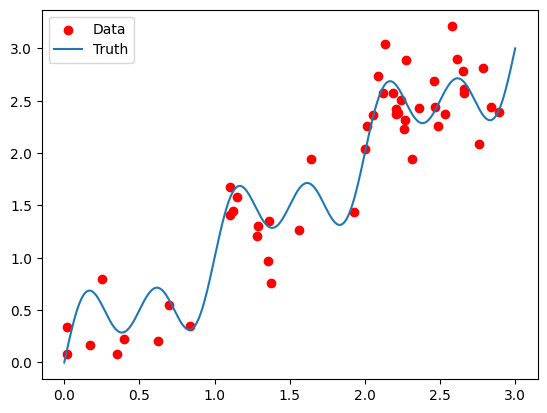

In [6]:
plt.scatter(X,Y,c='r',label='Data')
plt.plot(Xplot,Yplot, label = 'Truth')
plt.legend()

In [77]:
# Define the architecture of the neural network
class FeedForwardNN(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        
        self.layer1 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
        self.layer2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.layer3 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(output_dim, activation=None)
        self.concat_layer = tf.keras.layers.Concatenate()
        
        self.confidence_layer1 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.confidence_layer2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.confidence_layer3 = tf.keras.layers.Dense(output_dim, activation=None)

    def call(self, inputs):
        x      = self.layer1(inputs)
        x      = self.layer2(x)
        x      = self.layer3(x)

        output = self.output_layer(x)
        x      = self.concat_layer([x,output])
        x      = self.confidence_layer1(x)
        x      = self.confidence_layer2(x)
        sigma  = self.confidence_layer3(x)
        return  tf.stack([output,sigma])
    
    
# Define the architecture of the neural network
class BDeepONet(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BDeepONet, self).__init__()
        self.layer1 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
        self.layer2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.layer3 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        
        self.layer4 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
        self.layer5 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.layer6 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        
        self.output_layer = tf.keras.layers.Dense(output_dim, activation=None)
        self.concat_layer = tf.keras.layers.Concatenate()
        self.confidence_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x      = self.layer1(inputs)
        x      = self.layer2(x)
        x      = self.layer3(x)
        
        s      = tf.random.normal([50,1])
        s      = self.layer4(s)
        s      = self.layer5(s)
        s      = self.layer6(s)
        

        output = self.output_layer(tf.multiply(x,s))
        x      = self.concat_layer([x,output])
        sigma  = self.confidence_layer(x)
        return  tf.stack([output,sigma])


In [102]:
class MyCustomLoss(tf.keras.losses.Loss):
    # initialize instance attributes
    def __init__(self, threshold=1):
        super(MyCustomLoss, self).__init__()
        self.loss_balance_param = 5

    # Compute loss
    def call(self, y_true, nn_output):
        y_pred, log_sigma = tf.unstack(nn_output)
        # y_pred = y_pred
        # log_sigma = log_sigma

        scaled_data_loss = tf.multiply(tf.exp(-log_sigma) , tf.square(y_true - y_pred))

        uncertainty_loss = log_sigma
        loss = self.loss_balance_param*scaled_data_loss + uncertainty_loss
        loss = tf.reduce_sum(loss)

        return loss

In [120]:
# Create the model
model = FeedForwardNN(input_dim, hidden_dim, output_dim)
# model = BDeepONet(input_dim, hidden_dim, output_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate),
              loss=MyCustomLoss())

In [121]:
model.loss.loss_balance_param =20

In [122]:
model.loss(y_train, model(x_train))

<tf.Tensor: shape=(), dtype=float32, numpy=3170.3008>

In [123]:
model.optimizer.learning_rate = 0.001
epochs = 1000
batch_size = 64

In [134]:
# Train the model
hist = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

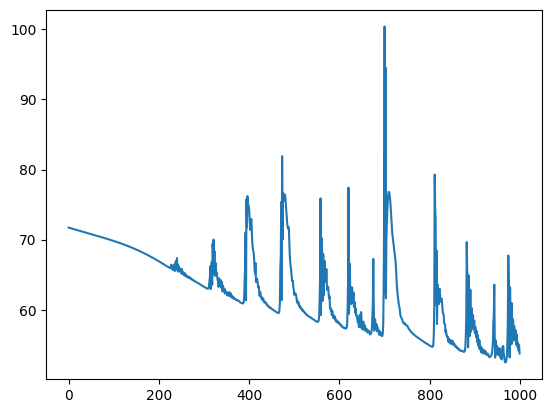

In [135]:
plt.plot(hist.history['loss'])

In [136]:
# def test_model(model, numSamples = 1000):
numSamples = 100

pi    = np.pi
X     = tf.cast(np.linspace(start=0, stop=5, num=numSamples), dtype='float32')
Y     = f(X)
X     = tf.reshape(X, (numSamples, input_dim))
out   = model(X)
y_pred, log_sigma = tf.unstack(out)


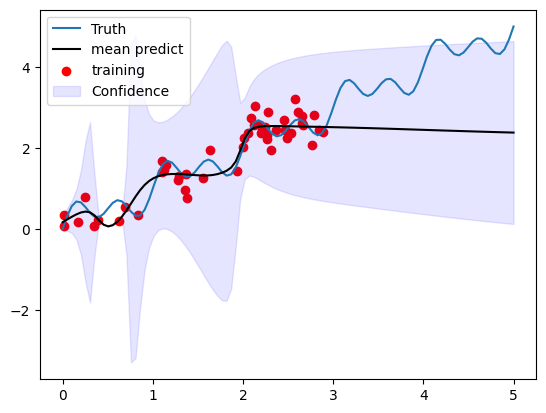

In [137]:
sig = tf.exp(log_sigma)
fig, ax = plt.subplots()
ax.plot(X,Y, label = 'Truth')
ax.plot(X, y_pred, c='k', label = 'mean predict')
ax.scatter(x_train, y_train, c='r', label = 'training')
ax.fill_between(tf.squeeze(X), tf.squeeze(y_pred-1*sig),
                tf.squeeze(y_pred+1*sig), color='b',
                alpha=.1, label = 'Confidence',
                interpolate=True)
ax.legend()


In [99]:
sig

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[0.09634245],
       [0.00129746],
       [0.0725157 ],
       [0.03357154],
       [0.08245946],
       [0.12245506],
       [0.15647848],
       [0.15785553],
       [0.01217671],
       [0.28106362],
       [0.80379385],
       [0.48816583],
       [0.02805083],
       [0.00293909],
       [0.23094106],
       [0.26754817],
       [0.2945076 ],
       [0.32426322],
       [0.22425842],
       [0.12825438],
       [0.07399139],
       [0.04773648],
       [0.03594526],
       [0.03155458],
       [0.03167306],
       [0.03544042],
       [0.042839  ],
       [0.05392096],
       [0.06828351],
       [0.08496469],
       [0.1027493 ],
       [0.120562  ],
       [0.13766553],
       [0.15365802],
       [0.16837925],
       [0.18181702],
       [0.1940329 ],
       [0.20512266],
       [0.21519157],
       [0.22434273],
       [0.2326725 ],
       [0.24026641],
       [0.24720272],
       [0.2535492 ],
       [0.25936615],
     